In [6]:
#from utils import *

import time
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [31]:
def parser(x):
    """
    Converts Google Finance Datetime format into YYYY-MM-DD
    """
    ts = datetime.datetime.strptime(x,'%m/%d/%Y %H:%M:%S')
    return datetime.datetime.strftime(ts, '%Y-%m-%d')

In [35]:
goog_df = pd.read_csv('data/GOOG.csv', header=0, parse_dates=[0], date_parser=parser)
gs_df = pd.read_csv('data/GS.csv', header=0, parse_dates=[0], date_parser=parser)
msft_df = pd.read_csv('data/MSFT.csv', header=0, parse_dates=[0], date_parser=parser)

In [51]:
goog_df.head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,313.73,314.75,312.12,313.37,1957963
1,2010-01-05,313.92,313.92,310.76,311.99,3007857
2,2010-01-06,312.54,312.93,303.18,304.13,3980628
3,2010-01-07,304.63,305.00,296.32,297.05,6418020
4,2010-01-08,296.18,301.62,294.55,301.01,4724735


## Preliminary plots of Closing Prices

In [38]:
train_test_split_date = datetime.date(2016,4, 20)

In [46]:
def plot_stock_prices(in_df, var, stock_name):
    plt.figure(figsize=(14, 5), dpi=100)
    label_str = stock_name + ' stock'
    title_str = stock_name + ' stock price (' + var + ')'
    plt.plot(in_df['Date'], in_df[var], label=label_str)
    plt.vlines(datetime.date(2016,4, 20), 0, 1.05*max(in_df[var]), linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.title(title_str)
    plt.legend()
    plt.show()

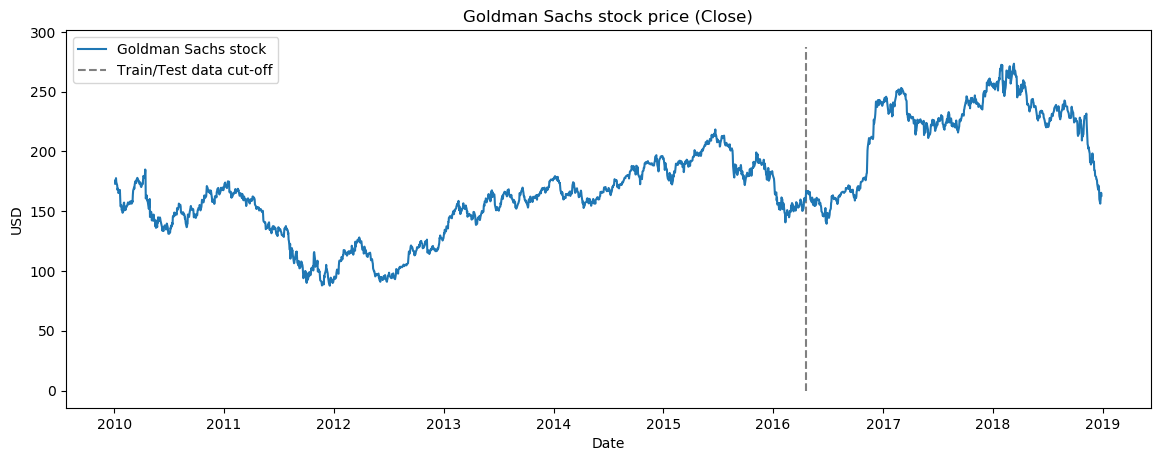

In [47]:
plot_stock_prices(gs_df, 'Close', 'Goldman Sachs')

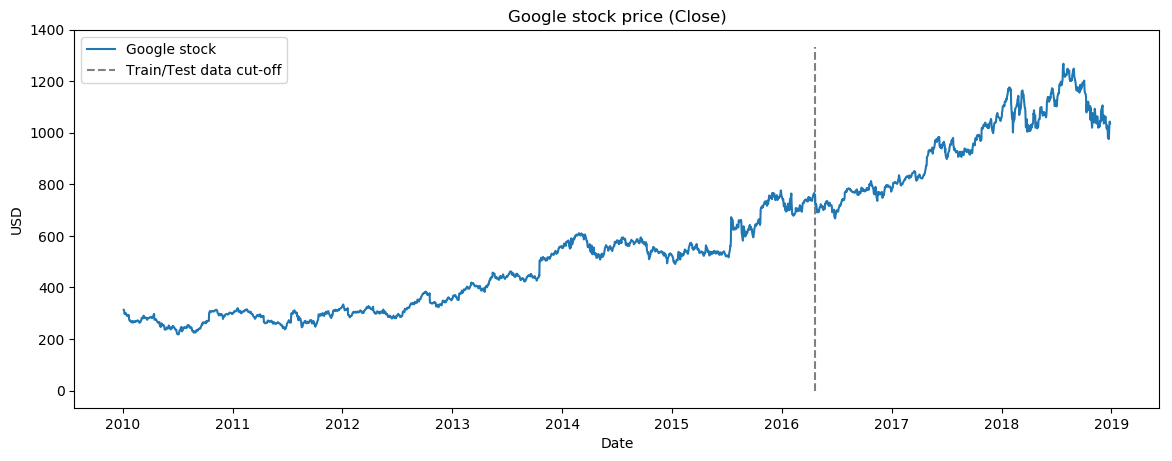

In [48]:
plot_stock_prices(goog_df, 'Close', 'Google')

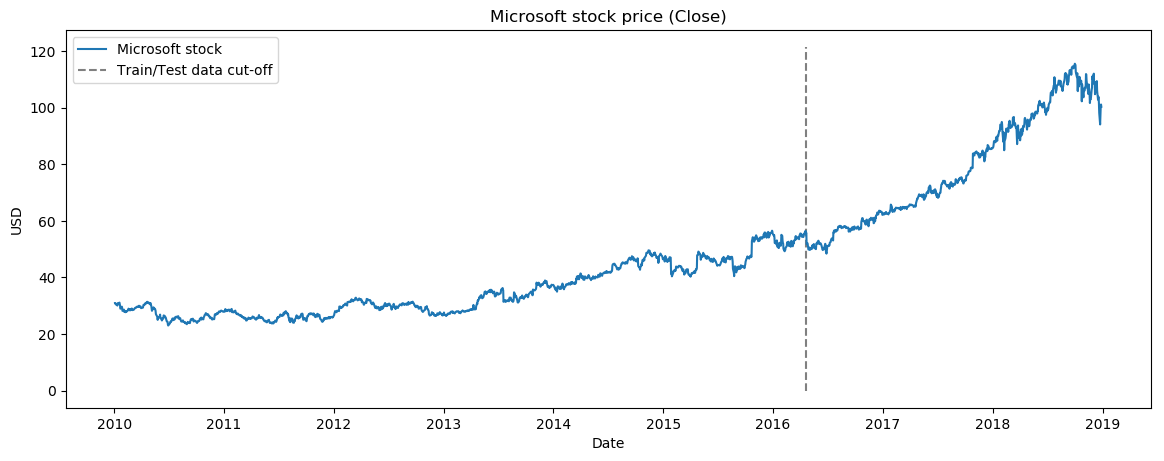

In [49]:
plot_stock_prices(msft_df, 'Close', 'Microsoft')

## Technical Indicators

In [112]:
def get_technical_indicators(in_df, var):
    # Create 7 and 21 days Moving Average
    in_df['ma7'] = in_df[var].rolling(window=7).mean()
    in_df['ma14'] = in_df[var].rolling(window=14).mean()
    in_df['ma21'] = in_df[var].rolling(window=21).mean()
    in_df['ma28'] = in_df[var].rolling(window=28).mean()
    
    # Create MACD
    in_df['26ema'] = pd.ewma(in_df[var], span=26)
    in_df['12ema'] = pd.ewma(in_df[var], span=12)
    in_df['MACD'] = (in_df['12ema']-in_df['26ema'])

    # Create Bollinger Bands
    in_df['20sd'] = pd.stats.moments.rolling_std(in_df[var],20)
    in_df['upper_band'] = in_df['ma21'] + (in_df['20sd']*2)
    in_df['lower_band'] = in_df['ma21'] - (in_df['20sd']*2)
    
    # Create Exponential moving average
    in_df['ema'] = in_df[var].ewm(com=0.5).mean()
    
    # Create Momentum
    in_df['momentum'] = in_df[var]-1
    
    return in_df

In [58]:
gs_TI_df = get_technical_indicators(gs_df, 'Close')
goog_TI_df = get_technical_indicators(goog_df, 'Close')
msft_TI_df = get_technical_indicators(msft_df, 'Close')

d:\python36\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  import sys
d:\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  
d:\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  if sys.path[0] == '':


In [57]:
gs_TI_df.head()

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2010-01-04,170.05,174.25,169.51,173.08,9138979,NaN,NaN,173.080000,173.080000,0.000000,NaN,NaN,NaN,173.080000,172.08
1,2010-01-05,173.00,176.26,172.57,176.14,11667885,NaN,NaN,174.668846,174.737500,0.068654,NaN,NaN,NaN,175.375000,175.14
2,2010-01-06,175.38,175.38,173.76,174.26,7382071,NaN,NaN,174.521952,174.551132,0.029180,NaN,NaN,NaN,174.603077,173.26
3,2010-01-07,174.32,178.75,173.95,177.67,8727377,NaN,NaN,175.402008,175.535636,0.133628,NaN,NaN,NaN,176.673250,176.67
4,2010-01-08,176.33,177.43,173.95,174.31,7270763,NaN,NaN,175.148767,175.202635,0.053868,NaN,NaN,NaN,175.091240,173.31


In [59]:
## Plot Technical Indicators

In [70]:
def plot_technical_indicators(dataset, var, last_days, label):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[var],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for ' + label + ' - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

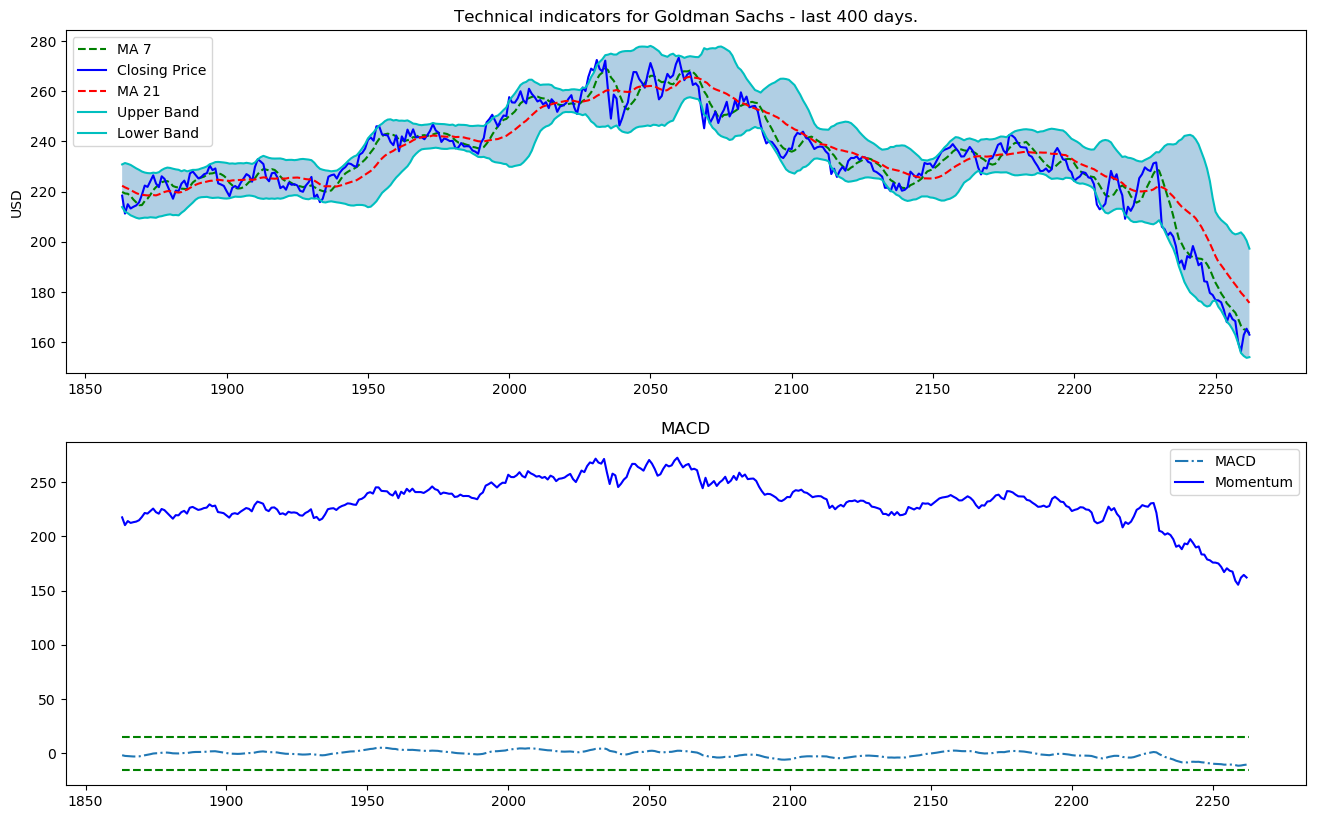

In [71]:
plot_technical_indicators(gs_TI_df, 'Close', 400, 'Goldman Sachs')

## Fourier Transforms

In [69]:
gs_FT_df = calc_fft_feat(gs_df, 'Close')

In [108]:
gs_FT_df

,fft,absolute,angle
0,(391116.44999999995+0j),391116.450000,0.000000
1,(15419.644109377632+50800.14145795687j),53088.791629,1.276099
2,(21858.779672401066+20607.71909584054j),30041.377051,0.755947
3,(-10740.960995767487+8682.649711115024j),13811.468029,2.461770
4,(-16623.108961426864-1357.3538144350737j),16678.434007,-3.060119
5,(4372.89560500822+7959.674682127772j),9081.774993,1.068428
6,(-4576.816753169074+11272.780040030453j),12166.462979,1.956470
7,(-4649.400715916313+3293.3498564059855j),5697.638133,2.525292
8,(3750.691324253309-3010.374173842563j),4809.369821,-0.676336
9,(5469.238379927666-2816.250192462839j),6151.734195,-0.475517


In [68]:
def calc_fft_feat(in_df, var):
    close_fft = np.fft.fft(np.asarray(in_df[var].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    
    return fft_df

In [78]:
def plot_fft(in_df, fft_df, var, label):
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(in_df[var],  label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title(label + ' (' + var + ') stock prices & Fourier transforms')
    plt.legend()
    plt.show()

In [100]:
fft_list = np.asarray(gs_FT_df['fft'].tolist())

In [101]:
fft_list

array([391116.45          +0.j        ,  15419.64410938+50800.14145796j,
        21858.7796724 +20607.71909584j, ...,
       -10740.96099577 -8682.64971112j,  21858.7796724 -20607.71909584j,
        15419.64410938-50800.14145796j])

In [107]:
len(fft_list)

2263

In [102]:
fft_list_m10= np.copy(fft_list)

In [104]:
fft_list_m10[3:-3]=0

In [105]:
fft_list_m10

array([391116.45          +0.j        ,  15419.64410938+50800.14145796j,
        21858.7796724 +20607.71909584j, ...,
       -10740.96099577 -8682.64971112j,  21858.7796724 -20607.71909584j,
        15419.64410938-50800.14145796j])

In [106]:
np.fft.ifft(fft_list_m10)

array([201.03063923-3.83678732j, 200.77270755-3.79712028j,
       200.51441072-3.7571898j , ..., 201.80218038-3.95418036j,
       201.54538194-3.91532009j, 201.28819946-3.87618817j])

d:\python36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


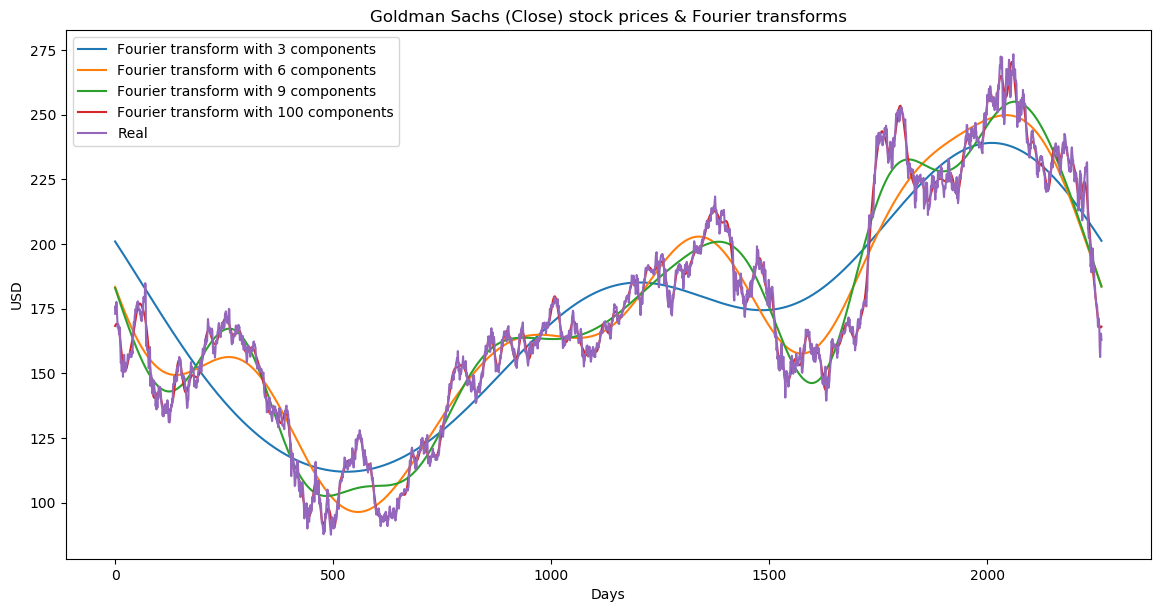

In [79]:
plot_fft(gs_df, gs_FT_df, 'Close', 'Goldman Sachs')

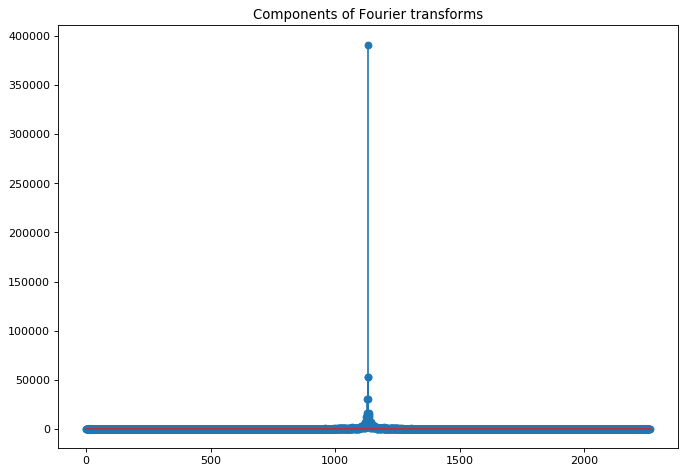

In [77]:
from collections import deque
items = deque(np.asarray(gs_FT_df['absolute'].tolist()))
items.rotate(int(np.floor(len(gs_FT_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Components of Fourier transforms')
plt.show()

## ARIMA

In [84]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = gs_df['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

d:\python36\lib\site-packages\scipy\signal\signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
d:\python36\lib\site-packages\scipy\signal\signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
d:\python36\lib\site-packages\scipy\signal\signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2262
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5457.989
Method:                       css-mle   S.D. of innovations              2.702
Date:                Fri, 05 Apr 2019   AIC                          10929.978
Time:                        17:41:13   BIC                          10970.046
Sample:                             1   HQIC                         10944.599
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0043      0.054     -0.080      0.936      -0.110       0.101
ar.L1.D.Close    -0.0210      0.021     -0.999      0.318      -0.062       0.020
ar.L2.D.Close     0.0148      0.021     

In [109]:
model_fit

d:\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


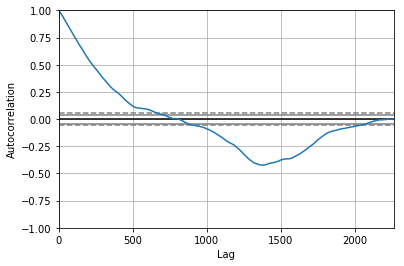

<Figure size 800x560 with 0 Axes>

In [85]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [94]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

d:\python36\lib\site-packages\scipy\signal\signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
d:\python36\lib\site-packages\scipy\signal\signaltools.py:1336: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
d:\python36\lib\site-packages\scipy\signal\signaltools.py:1342: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wi

In [118]:
len(history)

2263

In [110]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2261
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5454.813
Method:                       css-mle   S.D. of innovations              2.701
Date:                Sun, 07 Apr 2019   AIC                          10925.627
Time:                        20:22:21   BIC                          10971.415
Sample:                             1   HQIC                         10942.335
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.055     -0.062      0.951      -0.112       0.105
ar.L1.D.y     -0.0192      0.021     -0.915      0.360      -0.060       0.022
ar.L2.D.y      0.0157      0.021      0.744      0.4

In [95]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 10.144


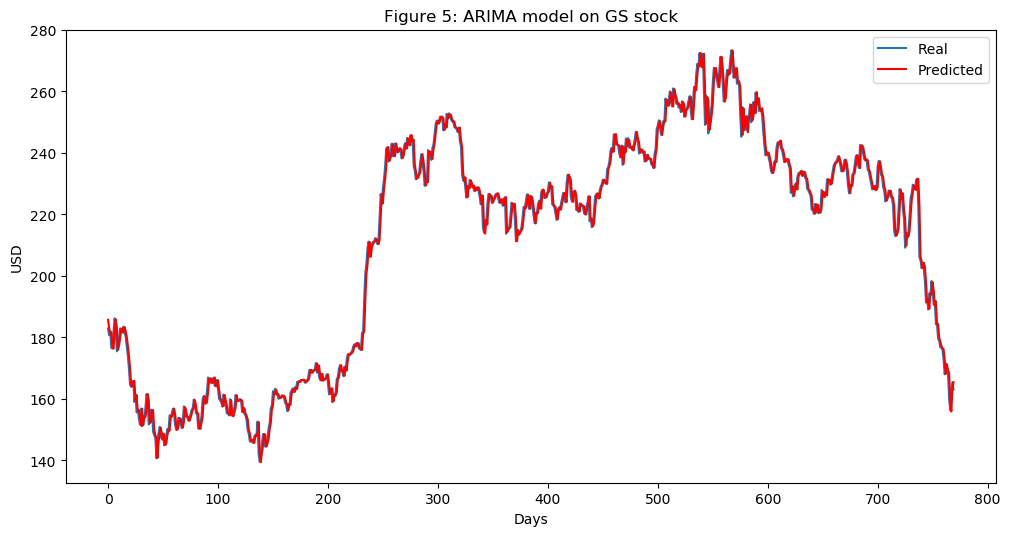

In [96]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

## Combining Features

Closing Price

Open, High, Low, Volume - 4 Features

Technical Indicator Features:
* 7, 14, 21, 28 Day MA
* 12, 26 Day EMA
* MACD
* Bollinger Bands (Upper and Lower)
* EMA
* Momentum
Total = 11 Features

FFT Features:
* 3, 6, 9, 15 Components Prediction
Total = 4 Features

ARIMA Features:
* ARIMA(5,1,0) Prediction


In [114]:
def fft_pred(in_df, fft_df):
    out_df = in_df
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 15]:
        fft_list_m10 = np.copy(fft_list)
        fft_list_m10[num_:-num_]=0
        var_str = 'fft' + str(num_)
        out_df[var_str] = np.fft.ifft(fft_list_m10)
    return out_df

In [119]:
def arima_pred(in_df, var):
    series = in_df[var]
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    out_df = in_df
    out_df['arima'] = history
    
    return out_df
    

In [117]:
gs_TI_df = get_technical_indicators(gs_df, 'Close')
gs_fft_df = calc_fft_feat(gs_df, 'Close')
gs_FT_df = fft_pred(gs_df, gs_fft_df)
gs_arima_df = arima_pred(gs_df, 'Close')

d:\python36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':
d:\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  # Remove the CWD from sys.path while we load stuff.
d:\python36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  
d:\python36\lib\site-packages\scipy\signal\signaltools.py:1333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as

ValueError: Length of values does not match length of index

In [130]:
gs_df.head() # Note: Already has all the feaures because we didn't make a new copy of the original dataframe

,Date,Open,High,Low,Close,Volume,ma7,ma21,26ema,12ema,...,lower_band,ema,momentum,ma14,ma28,fft3,fft6,fft9,fft15,arima
0,2010-01-04,170.05,174.25,169.51,173.08,9138979,NaN,NaN,173.080000,173.080000,...,NaN,173.080000,172.08,NaN,NaN,(201.0306392257136-3.83678732263147j),(183.43532130181885-4.98134336722512j),(183.03541093656588+1.2444764438633868j),(179.45986012766892-1.6695128664181997j),173.08
1,2010-01-05,173.00,176.26,172.57,176.14,11667885,NaN,NaN,174.668846,174.737500,...,NaN,175.375000,175.14,NaN,NaN,(200.77270754799338-3.7971202825104515j),(182.97909863280043-4.946961829677889j),(182.5293120475716+1.183702113146773j),(178.8015386119197-1.627213198442566j),176.14
2,2010-01-06,175.38,175.38,173.76,174.26,7382071,NaN,NaN,174.521952,174.551132,...,NaN,174.603077,173.26,NaN,NaN,(200.51441071904966-3.7571898004093605j),(182.52451088664262-4.911207446691673j),(182.0238133876308+1.122188695585697j),(178.15054046433758-1.5820915446238693j),174.26
3,2010-01-07,174.32,178.75,173.95,177.67,8727377,NaN,NaN,175.402008,175.535636,...,NaN,176.673250,176.67,NaN,NaN,(200.25575502980286-3.7169986466816525j),(182.07160637832396-4.874090140566932j),(181.51896062107113+1.0599745992873697j),(177.50707215747596-1.534226156950495j),177.67
4,2010-01-08,176.33,177.43,173.95,174.31,7270763,NaN,NaN,175.148767,175.202635,...,NaN,175.091240,173.31,NaN,NaN,(199.99674676699223-3.6765496097660124j),(181.6204331402339-4.835620211832789j),(181.0148001592557+0.9970986698529033j),(176.87133023002673-1.4837000457166722j),174.31


In [131]:
print('Total dataset has {} samples, and {} features.'.format(gs_df.shape[0], \
                                                              gs_df.shape[1]))

Total dataset has 2263 samples, and 23 features.


## Feature Importance

In [171]:
def get_feature_importance_data(in_df):
    X = in_df.copy()
    X = X[['Close', 'ma7', 'ma14', 'ma21', 'ma28', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band']]
    y = X['Close']
    X.drop('Close',axis=1, inplace=True)
    
    train_samples = int(X.shape[0] * 0.66)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [172]:
(X_train, y_train), (X_test, y_test) = get_feature_importance_data(gs_df)

In [173]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [174]:
xgbModel = regressor.fit(X_train,y_train, \
                         eval_set = [(X_train, y_train), (X_test, y_test)], \
                         verbose=False)

In [175]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

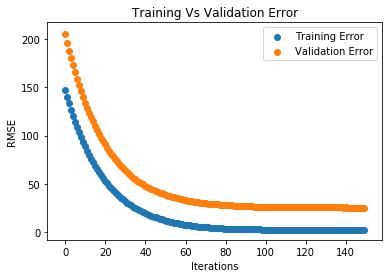

In [176]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

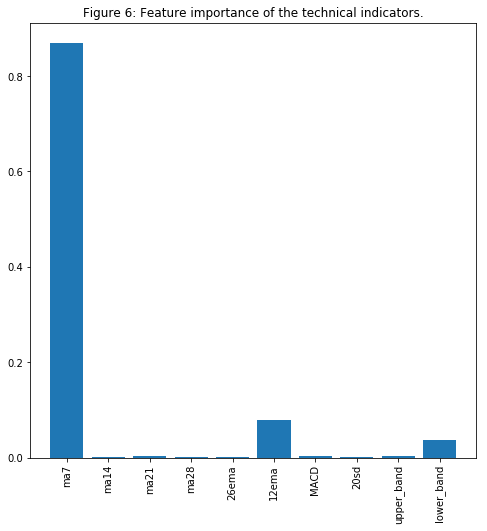

In [177]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show() # This is different from what he got in his notebook?!